In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import polyphase as phase
import matplotlib.pyplot as plt


In [3]:
SAVE_FIGS = False

## Result 1: Plot three different types of phase diagrams

In [4]:
def plot_energy_landscape(engine):
    grid = engine.grid
    energy = engine.energy

    labels = engine.df.loc['label',:].to_numpy()
    boundary_points= np.asarray([phase.is_boundary_point(x) for x in grid.T])

    fig = plt.figure(figsize=(4*1.6, 4))
    ax = fig.add_subplot(projection='3d')
    ax.plot_trisurf(grid[0,~boundary_points], grid[1,~boundary_points], 
                    energy[~boundary_points], 
                    linewidth=0.01, antialiased=True)
    ax.axis('off')
    plt.tight_layout()
    
    return ax,fig

def plot_result1(func, fname):
    engine = phase.PHASE(f,100,3)
    engine.compute(use_parallel=False, verbose=False, lift_label=True)
    phase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
    plt.savefig('../figures/final/result1_{}PD.png'.format(fname), 
                dpi=400, bbox_inches='tight')
    
    plot_energy_landscape(engine)
    plt.savefig('../figures/final/result1_{}EL.png'.format(fname), 
            dpi=400, bbox_inches='tight')
    
    return

Computation took 0.78s


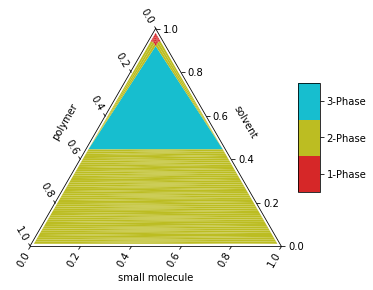

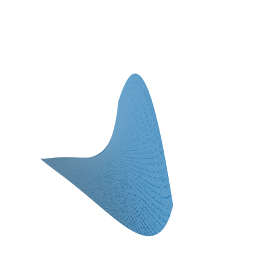

In [8]:
M = [10,10,1]
chi = [1.335, 1.0, 1.0]
f = lambda x : phase.flory_huggins(x, M, chi, logapprox=True)
plot_result1(f, 'type3')

In [ ]:
# type 1: classic parabola ternary
M = [5,5,1]
chi = [1, 0.5, 0.5]
f = lambda x : phase.flory_huggins(x, M, chi)
plot_result1(f, 'type1')
    
# type 2: One phase region near the polymer axis
M = [946,12,1]
chi = [0.472689,0.565626,0.651095]
f = lambda x : phase.flory_huggins(x, M, chi)
plot_result1(f, 'type2')


## Hyper parameter search plot
This plot takes a lot of time so we run it on CCR

dx=100, Delta=5
dx=100, Delta=10
dx=100, Delta=20
dx=200, Delta=5
dx=200, Delta=10
dx=200, Delta=20
dx=300, Delta=5
dx=300, Delta=10
dx=300, Delta=20


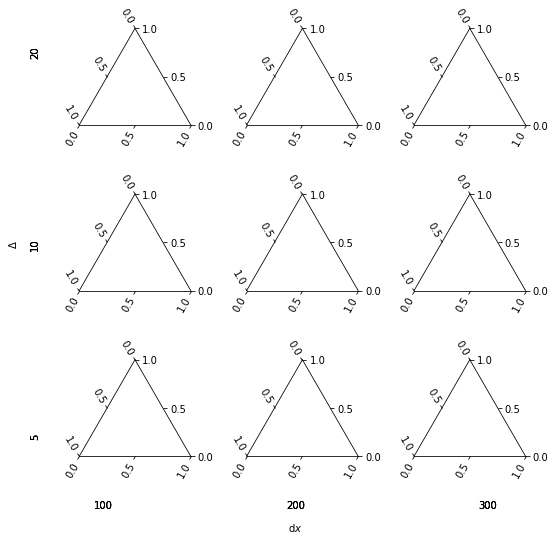

In [4]:
M = [5,5,1]
chi = [1, 0.5, 0.5]
f = lambda x : phase.flory_huggins(x, M, chi)
dxs = [100,200,300]
Deltas = [5,10,20]
fig,axs = plt.subplots(3,3,subplot_kw={'projection':'ternary'}, figsize=(8,8))
fig.subplots_adjust(wspace=0.5, hspace=0.6)
label_spacing = [1/6,3/6,5/6]
for i,dx in enumerate(dxs):
    for j, Delta in enumerate(Deltas):
#         engine = phase.PHASE(f,dx,3)
#         engine.compute(use_parallel=True, verbose=False,
#                        thresh_scale=Delta, lift_label=True)
#         ax, cbar = phase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps, ax=axs[i,j])
#         ax.set_tlabel('')
#         ax.set_llabel('')
#         ax.set_rlabel('')
#         cbar.remove()
        fig.text(label_spacing[i], 0.04, '{}'.format(dx), ha='center')
        fig.text(0.04, label_spacing[j], '{}'.format(Delta), va='center', rotation='vertical')
        print('dx={}, Delta={}'.format(dx, Delta))
#         break
#     break
fig.text(0.5, 0.0, r'd$x$', ha='center')
fig.text(0.0, 0.5, r'$\Delta$', va='center', rotation='vertical')
plt.show()

## Angles and dot products

In [6]:
f = lambda x : phase.polynomial_energy(x)
engine = phase.PHASE(f,100,3)
engine.compute(use_parallel=False, verbose=True, lift_label=True)

3-dimensional grid generated at 0.06s
Energy computed at 0.10s
Making energy manifold a paraboloid with 2x padding of 59.28 maximum energy
Energy is corrected at 0.26s
Convexhull is computed at 0.26s
Simplices are refined at 0.27s
Total of 325 simplices in the convex hull
Using 1.43E-01 as a threshold for Laplacian of a simplex
Simplices are labelled at 0.40s
Labels are lifted at 0.46s
Total 0/325 coplanar simplices
Computation took 0.46s


In [12]:
# gradients
grid = engine.grid
num_comps = engine.num_comps
simplices = engine.simplices
energy = engine.energy

# Central difference gradient computation
class CentralDifference:
    """Compute central difference gradinet of energy
    Works only for a 3-dimensional grid or a ternary system
    change the energy formulation
    """
    def __init__(self, grid, energy):
        if callable(energy):
            self.func = energy
        else:
            raise RuntimeError

    def __call__(self,phi, h = 1e-3):
        """
        x,y : coordinates (float)
        h   : gridspacing (float)

        """
        p1,p2,p3 = phi
        f_right = self.func([p1+h,p2,1-p1-h-p2])
        f_left = self.func([p1-h,p2,1-p1+h-p2])
        df_dx = (f_right - f_left)/(2*h)
        
        f_right = self.func([p1,p2+h,1-p1-h-p2])
        f_left = self.func([p1,p2-h,1-p1+h-p2])
        df_dy = (f_right - f_left)/(2*h)
        
        return [df_dx, df_dy]
    
centraldiff_gradient = CentralDifference(grid, f)    
grad_cd = np.asarray([centraldiff_gradient(phi, h = 1e-6) for phi in grid.T])

# Analytical gradient for polynomial free energy
def _grad_polynomial(x):
    
    grad = 2*(x-0.1)*(0.9-x)*(1-2*x)
    
    return grad*1e3

def polynomial_gradient(x,**kwargs):
    grad = []
    df_dx3 = 2*1e3*(0.9-x[0]-x[1])*(x[0]+x[1]-0.1)*(1-2*x[0]-2*x[1])
    for xi in x[:2]:
        df_dxi = _grad_polynomial(xi)
        grad.append(df_dxi + df_dx3)
        
    return grad

analytic_gradient = lambda phi : polynomial_gradient(phi)


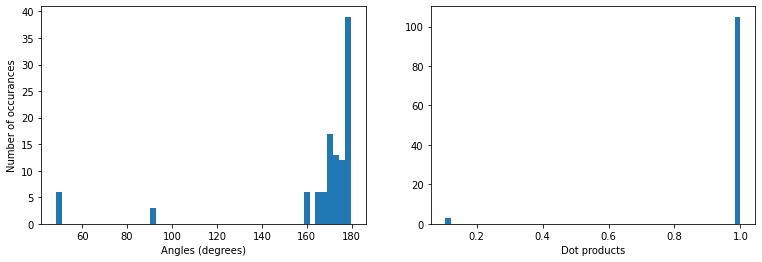

In [10]:
# get all angles of all 2-phase simplices
phase_simplices_ids = np.where(np.asarray(num_comps)==2)[0]
outlist = []
for simplex_id in phase_simplices_ids:
    test = phase.TestAngles(engine,phase=2,simplex_id=simplex_id)
    test_out = test.get_angles(centraldiff_gradient)
    for _, value in test_out['thetas'].items():
        outlist.append([value[2], value[3]])

outlist = np.asarray(outlist)        
assert len(outlist)==len(phase_simplices_ids)*3    
fig, axs = plt.subplots(1,2,figsize=(2*4*1.6, 4))
axs[0].hist(outlist[:,0],bins=50, density=False)
axs[0].set_xlabel('Angles (degrees)')
axs[0].set_ylabel('Number of occurances')
axs[1].hist(outlist[:,1],bins=50, density=False)
axs[1].set_xlabel('Dot products')
plt.savefig('../figures/final/polynomial_angles_dotprods.png', dpi=400, bbox_inches='tight')

## Comparing gradient computations


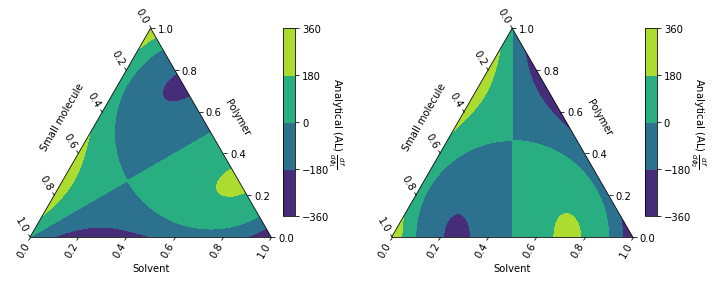

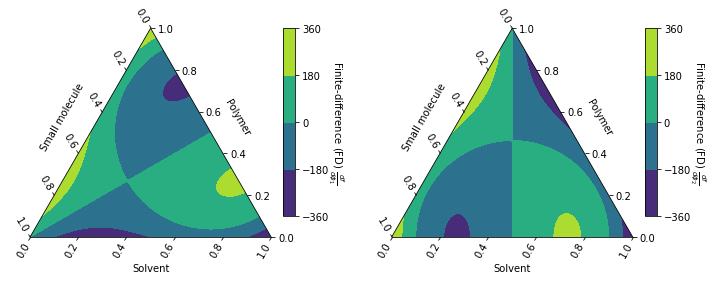

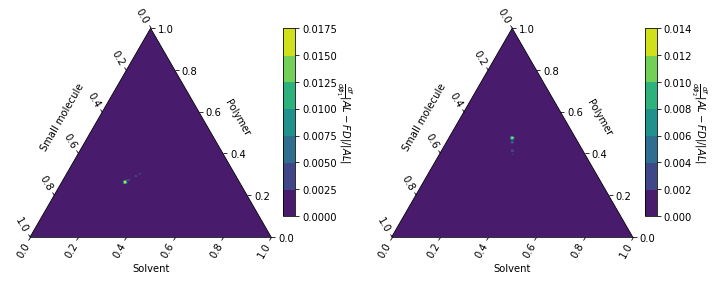

In [23]:
import matplotlib.gridspec as gridspec

def plot_gradient_field(grid, gradient, ax,**kwargs):
    fig = plt.gcf()
    cs = ax.tricontourf(grid[0,:], grid[1,:], grid[2,:], gradient,**kwargs)
    cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
    cbar = fig.colorbar(cs, cax=cax)
    
    ax.set_tlabel('Polymer')
    ax.set_llabel('Small molecule')
    ax.set_rlabel('Solvent')

    ax.taxis.set_label_position('tick1')
    ax.laxis.set_label_position('tick1')
    ax.raxis.set_label_position('tick1')
    ax.set_aspect('equal')
    
    return ax, cbar

grad = np.nan_to_num(np.asarray([analytic_gradient(x) for x in grid.T]))
grad_cd = np.nan_to_num(np.asarray([centraldiff_gradient(x, h = 1e-6) for x in grid.T]))

vmin=grad_cd.min()
vmax=grad_cd.max()
levels = np.linspace(vmin, vmax, num=5)

# a) analytical gradient
fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.5)

ax = fig.add_subplot(1, 2, 1, projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,0], ax, levels=levels)
cbar.set_label(r'Analytical (AL) $\frac{df}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(1, 2, 2, projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,1], ax, levels=levels)
cbar.set_label(r'Analytical (AL) $\frac{df}{d\phi_2}$', rotation=270, va='baseline')
plt.savefig('../figures/final/analytical_gradient_polynomial.png', dpi=400, bbox_inches='tight')

# b) Finite difference
fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.5)

ax = fig.add_subplot(1, 2, 1, projection='ternary')
ax,cbar = plot_gradient_field(grid, grad_cd[:,0], ax, levels=levels)
cbar.set_label(r'Finite-difference (FD) $\frac{df}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(1, 2, 2, projection='ternary')
ax,cbar = plot_gradient_field(grid,grad_cd[:,1], ax, levels=levels )
cbar.set_label(r'Finite-difference (FD) $\frac{df}{d\phi_2}$', rotation=270, va='baseline')
plt.savefig('../figures/final/finitediff_gradient_polynomial.png', dpi=400, bbox_inches='tight')

# difference
fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.5)

ax = fig.add_subplot(1, 2, 1, projection='ternary')
cvalue = np.abs(grad_cd[:,0]-grad[:,0])/np.abs(grad[:,0])
ax,cbar = plot_gradient_field(grid, cvalue, ax)
cbar.set_label(r'$\frac{df}{d\phi_1} |AL-FD|/|AL|$', rotation=270, va='baseline')

ax = fig.add_subplot(1, 2, 2, projection='ternary')
cvalue = np.abs(grad_cd[:,1]-grad[:,1])/np.abs(grad[:,1])
ax,cbar = plot_gradient_field(grid, cvalue, ax)
cbar.set_label(r'$\frac{df}{d\phi_2} |AL-FD|/|AL|$', rotation=270, va='baseline')
plt.savefig('../figures/final/comparision_polynomial.png', dpi=400, bbox_inches='tight')